# Imports

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import ticker
import numpy as np
import sqlite3
import zipfile as zf
import os
pd.set_option('display.float_format', lambda x: '%.0f' % x)

Data

In [2]:
bom = pd.read_csv('./data/bom.movie_gross.csv.gz')
tmdb = pd.read_csv('./data/tmdb.movies.csv.gz')
tn = pd.read_csv('./data/tn.movie_budgets.csv.gz')
files = zf.ZipFile('./data/im.db.zip', 'r') #these lines create a im.db file which is too big to push
files.extractall() #these lines create a im.db file which is too big to push
con = sqlite3.connect("./im.db")

In [3]:
titles = pd.read_sql("""
Select * 

From movie_basics
            
""", con)
titles.head(1)

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175,"Action,Crime,Drama"


In [4]:
rating = pd.read_sql("""
Select * 

From movie_ratings
            
""", con)

rating.head(1)

,movie_id,averagerating,numvotes
0,tt10356526,8,31


In [5]:
#creation of the merged table betweeen bom and tmdb
rating_and_gross = bom.merge(tmdb, how='inner', left_on='title', right_on='title').sort_values('domestic_gross', ascending=False)

In [6]:
#creation of merge table of the rating_and_gross with the tn table
budget_rating_gross =   rating_and_gross.merge(tn, how='inner', left_on='title', right_on='movie')

In [9]:
sql_df = pd.read_sql('''
    SELECT *
    
    FROM
    movie_ratings
    
    INNER JOIN movie_basics
        USING(movie_id) 
     
     WHERE numvotes >= 1000
     
     ORDER BY 
         averagerating DESC
''', con)

#We need to choose and averagerating number for a WHERE clause
#If we feel like we need more ratings data we can combine this with budget_rating_gross

Cleaning

In [10]:
budget_rating_gross.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1395 entries, 0 to 1394
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   title              1395 non-null   object 
 1   studio             1394 non-null   object 
 2   domestic_gross_x   1393 non-null   float64
 3   foreign_gross      1200 non-null   object 
 4   year               1395 non-null   int64  
 5   Unnamed: 0         1395 non-null   int64  
 6   genre_ids          1395 non-null   object 
 7   id_x               1395 non-null   int64  
 8   original_language  1395 non-null   object 
 9   original_title     1395 non-null   object 
 10  popularity         1395 non-null   float64
 11  release_date_x     1395 non-null   object 
 12  vote_average       1395 non-null   float64
 13  vote_count         1395 non-null   int64  
 14  id_y               1395 non-null   int64  
 15  release_date_y     1395 non-null   object 
 16  movie              1395 

There are 195 null values in the foreign_gross column, 2 in the domestic_gross_x column, and 1 in studio column.
There are duplicate and unnecessary columns. 

In [11]:
#dropping unnecessary columns
clean_columns = budget_rating_gross.drop(['release_date_y', 'Unnamed: 0', 'genre_ids', 'original_title', 'domestic_gross_x', 'foreign_gross', 'movie', 'id_x', 'id_y', 'original_language'], axis=1)
clean_columns.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1395 entries, 0 to 1394
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   title              1395 non-null   object 
 1   studio             1394 non-null   object 
 2   year               1395 non-null   int64  
 3   popularity         1395 non-null   float64
 4   release_date_x     1395 non-null   object 
 5   vote_average       1395 non-null   float64
 6   vote_count         1395 non-null   int64  
 7   production_budget  1395 non-null   object 
 8   domestic_gross_y   1395 non-null   object 
 9   worldwide_gross    1395 non-null   object 
dtypes: float64(2), int64(2), object(6)
memory usage: 119.9+ KB


In [12]:
#cleaning and converting worldwide_gross into int
clean_columns['worldwide_gross'] = clean_columns['worldwide_gross'].str.replace('$', '')
clean_columns['worldwide_gross'] = clean_columns['worldwide_gross'].str.replace(',', '')
clean_columns['worldwide_gross'] = clean_columns['worldwide_gross'].astype(int)

In [13]:
clean_columns['domestic_gross_y'] = clean_columns['domestic_gross_y'].str.replace('$', '')
clean_columns['domestic_gross_y'] = clean_columns['domestic_gross_y'].str.replace(',', '')
clean_columns['domestic_gross_y'] = clean_columns['domestic_gross_y'].astype(int)

In [14]:
clean_columns['production_budget'] = clean_columns['production_budget'].str.replace('$', '')
clean_columns['production_budget'] = clean_columns['production_budget'].str.replace(',', '')
clean_columns['production_budget'] = clean_columns['production_budget'].astype(int)

In [15]:
#Sanity Check
clean_columns.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1395 entries, 0 to 1394
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   title              1395 non-null   object 
 1   studio             1394 non-null   object 
 2   year               1395 non-null   int64  
 3   popularity         1395 non-null   float64
 4   release_date_x     1395 non-null   object 
 5   vote_average       1395 non-null   float64
 6   vote_count         1395 non-null   int64  
 7   production_budget  1395 non-null   int64  
 8   domestic_gross_y   1395 non-null   int64  
 9   worldwide_gross    1395 non-null   int64  
dtypes: float64(2), int64(5), object(3)
memory usage: 119.9+ KB


In [16]:
#dropping exact row duplicates
test_clean_columns = clean_columns.drop_duplicates()

In [17]:
#dropping duplicates where the title name is the same but other values are wrong
vote_count_max = test_clean_columns.groupby(['title','studio']).vote_count.transform(max)
movies_clean = test_clean_columns.loc[test_clean_columns.vote_count == vote_count_max]

In [18]:
#Sanity Check: verifying the shape of movies_clean
movies_clean.shape

(1178, 10)

In [19]:
movies_sql = movies_clean.merge(sql_df, how='inner', left_on='title', right_on='original_title')

# Data Analyzation

In [20]:
#Quick glance at the information of the dataset
movies_clean.describe()
# min value for production_budget is > 0.

,year,popularity,vote_average,vote_count,production_budget,domestic_gross_y,worldwide_gross
count,1178,1178,1178,1178,1178,1178,1178
mean,2014,14,6,2367,48386286,62659066,157680828
std,3,8,1,2948,56852662,86365294,239943493
min,2010,1,3,1,50000,0,0
25%,2011,9,6,486,10000000,8631720,18894285
50%,2014,12,6,1288,28000000,34551211,68574438
75%,2016,16,7,2989,60000000,77510697,180123619
max,2018,81,8,22186,410600000,700059566,2048134200


In [21]:
#Dropping outliers from worldwide_gross
q3, q1 = np.percentile(movies_clean['worldwide_gross'], [75, 25])
q3, q1
iqr = q3-q1

lower_limit_wwg = movies_clean['worldwide_gross'].mean()-(iqr*1.5)

upper_limit_wwg = movies_clean['worldwide_gross'].mean()+(iqr*1.5)

lower_limit_wwg, upper_limit_wwg

(-84163172.32470289, 399524828.17529714)

In [22]:
movies_without_wwg_outliers = movies_clean[movies_clean['worldwide_gross']<upper_limit_wwg]

In [23]:
#Dropping outliers from production_budget
q3, q1 = np.percentile(movies_without_wwg_outliers['production_budget'], [75, 25])
q3, q1
iqr = q3-q1

lower_limit_pb = movies_without_wwg_outliers['production_budget'].mean()-(iqr*1.5)

upper_limit_pb = movies_without_wwg_outliers['production_budget'].mean()+(iqr*1.5)

lower_limit_pb, upper_limit_pb

(-16794264.684060723, 88205735.31593928)

In [24]:
movies_without_wwg_or_pb_outliers = movies_without_wwg_outliers[movies_without_wwg_outliers['production_budget']<upper_limit_pb]

# Production Budget

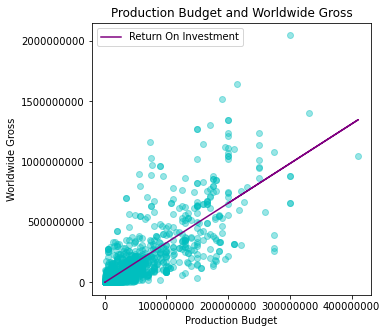

In [25]:
fig, ax = plt.subplots(figsize=(5,5))
ax.ticklabel_format(style='plain')
ax.scatter(clean_columns['production_budget'] , y = clean_columns['worldwide_gross'], alpha = .4, c="c");

x=clean_columns['production_budget']
y=clean_columns['worldwide_gross']
m, b = np.polyfit(x,y,1)
plt.plot(x, m*x + b, c="purple")
plt.legend(['Return On Investment'])

ax.set_title('Production Budget and Worldwide Gross')
ax.set_xlabel('Production Budget')
ax.set_ylabel('Worldwide Gross');

In [39]:
plt.savefig('./Untitled Folder/Production Budget and Worldwide Gross.png')

<Figure size 432x288 with 0 Axes>

In [26]:
np.corrcoef(clean_columns['production_budget'] , y = clean_columns['worldwide_gross'])[0][1]

0.7791286442845019

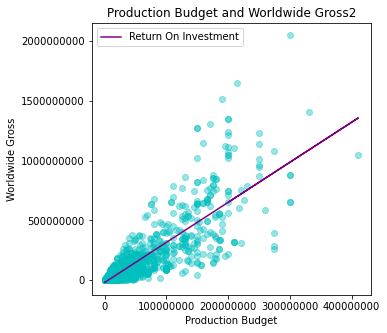

In [40]:
clean_columns['gross_to_budget_ratio'] = clean_columns['worldwide_gross'] / clean_columns['production_budget']

#Make to help determining bounds of the graph
q3, q1 = np.percentile(clean_columns['gross_to_budget_ratio'], [75, 25])
q3, q1
iqr = q3-q1

lower_limit = clean_columns['gross_to_budget_ratio'].mean()-(iqr*1.5)

upper_limit = clean_columns['gross_to_budget_ratio'].mean()+(iqr*1.5)

lower_limit, upper_limit

#limiting data to the upper limit of the iqr
movies_oultierless = clean_columns[clean_columns['gross_to_budget_ratio']<upper_limit]


#graph of movies_oultierless
fig, ax = plt.subplots(figsize=(5,5))
ax.ticklabel_format(style='plain')
ax.scatter(movies_oultierless['production_budget'] , y = movies_oultierless['worldwide_gross'], alpha = .4, c="c");

x=movies_oultierless['production_budget']
y=movies_oultierless['worldwide_gross']
m, b = np.polyfit(x,y,1)
plt.plot(x, m*x + b, c="purple")
plt.legend(['Return On Investment'])


ax.set_title('Production Budget and Worldwide Gross2')
ax.set_xlabel('Production Budget')
ax.set_ylabel('Worldwide Gross');


In [41]:
plt.savefig('./Untitled Folder/Production Budget and Worldwide Gross2.png')

<Figure size 432x288 with 0 Axes>

In [28]:
#Removed outliers based on gross_to_budget_ratio. The correlation was very strong and positive.
np.corrcoef(movies_oultierless['production_budget'] , y = movies_oultierless['worldwide_gross'])[0][1]
#almost a 1:1 correlation

0.8237321948182371

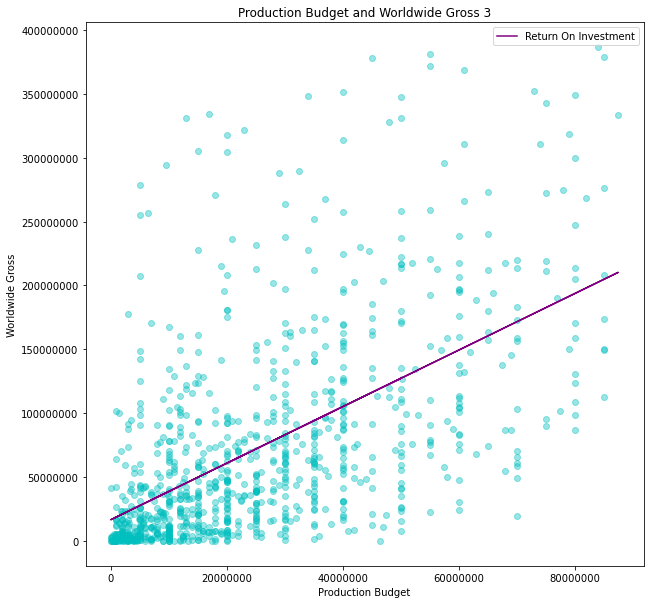

In [43]:
fig, ax = plt.subplots(figsize=(10,10),)
ax.ticklabel_format(style='plain')
ax.scatter(movies_without_wwg_or_pb_outliers['production_budget'] , y = movies_without_wwg_or_pb_outliers['worldwide_gross'], alpha = .4, c="c")


x=movies_without_wwg_or_pb_outliers['production_budget']
y=movies_without_wwg_or_pb_outliers['worldwide_gross']
m, b = np.polyfit(x,y,1)
plt.plot(x, m*x + b, c="purple")
plt.legend(['Return On Investment'])


ax.set_title('Production Budget and Worldwide Gross 3')
ax.set_xlabel('Production Budget')
ax.set_ylabel('Worldwide Gross');


In [44]:
plt.savefig('./Untitled Folder/Production Budget and Worldwide Gross 3.png')

<Figure size 432x288 with 0 Axes>

In [30]:
#checking the correlation coefficient of movies_without_wwg_or_pb_outliers
np.corrcoef(movies_without_wwg_or_pb_outliers['production_budget'] , y = movies_without_wwg_or_pb_outliers['worldwide_gross'])[0][1]
#postive correlation but not as strong as the movie_oultierless

0.5792614674829253

# Movie Genre

In [31]:
#genres vs averagerating
genres_average_rating = sql_df.groupby(['genres']).mean(['averagerating']).sort_values(['averagerating'], ascending=False).head(20)
genres_average_rating
#Low vote counts

,averagerating,numvotes,start_year,runtime_minutes
genres,,,,
"Action,Romance,War",8,1224,2018,130
"Animation,History",8,7451,2014,135
"Drama,Family,Thriller",8,2996,2014,150
"Animation,Documentary,Mystery",8,1014,2017,93
War,8,2437,2011,96
Musical,8,1724,2015,121
"Biography,Documentary,News",8,7848,2015,73
"Documentary,History,Sport",8,1889,2015,103
"Documentary,Family",8,2662,2013,89


<ipython-input-32-04502a159d44>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_sql2['worldwide_gross_mil'] = movies_sql2['worldwide_gross']/1000000


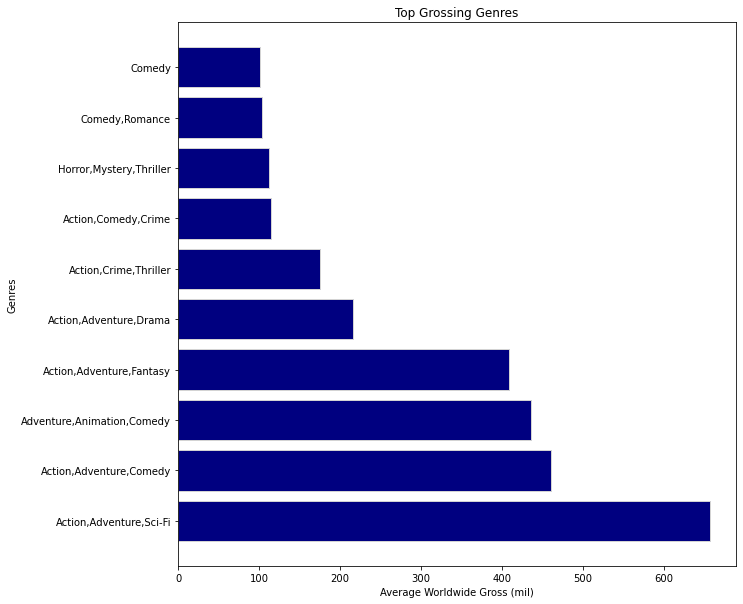

In [32]:


genres_list = pd.get_dummies(movies_sql.genres, prefix=None).sum().sort_values(ascending=False).head(20)
genres_list2 = list(genres_list.index)
movies_sql2 = movies_sql[movies_sql['genres'].isin(genres_list2)]
movies_sql2['worldwide_gross_mil'] = movies_sql2['worldwide_gross']/1000000
genres_vs_wwg = movies_sql2.groupby(['genres']).mean().sort_values(['worldwide_gross_mil'], ascending=False).head(10)

fig, ax = plt.subplots(figsize=(10,10))

ax.barh(y=genres_vs_wwg.index, width=genres_vs_wwg['worldwide_gross_mil'], color="navy", edgecolor="lightgrey")
ax.set_title('Top Grossing Genres')
ax.set_ylabel('Genres')
ax.set_xlabel('Average Worldwide Gross (mil)');


In [45]:
plt.savefig('./Untitled Folder/Top Grossing Genres.png')

<Figure size 432x288 with 0 Axes>

# Runtime

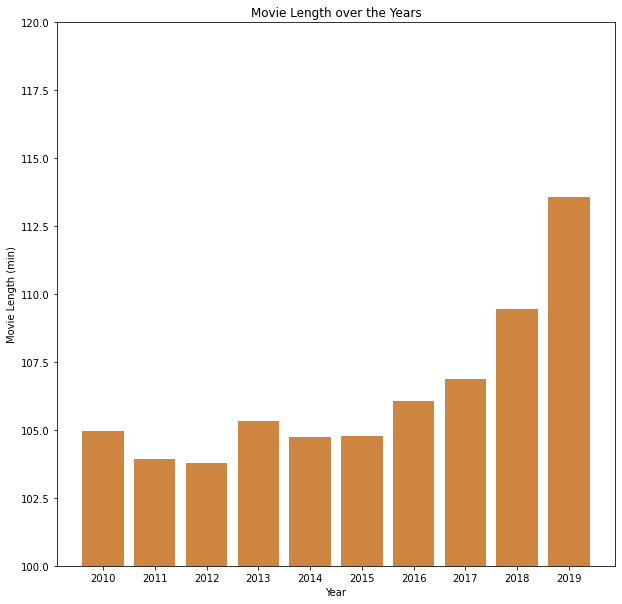

In [33]:
#runtime_minutes vs start_year
runtime_year = sql_df.groupby(['start_year']).mean(['runtime_minutes']).sort_values(['start_year'])
runtime_year

fig, ax = plt.subplots(figsize=(10,10))

ax.bar(x=runtime_year.index.astype(str), height=(runtime_year['runtime_minutes']), color="peru");
ax.set_ylim([100, 120])
#Started our chart with the y axis starting at 100 for visual purposes.

ax.set_title('Movie Length over the Years')
ax.set_xlabel('Year')
ax.set_ylabel('Movie Length (min)');



In [46]:
plt.savefig('./Untitled Folder/Movie Length over the Years.png')

<Figure size 432x288 with 0 Axes>

In [34]:
#stong positive correlation
#movies are getting longer!
np.corrcoef(runtime_year.index , y = runtime_year['runtime_minutes'])[0][1]

0.810556758544068

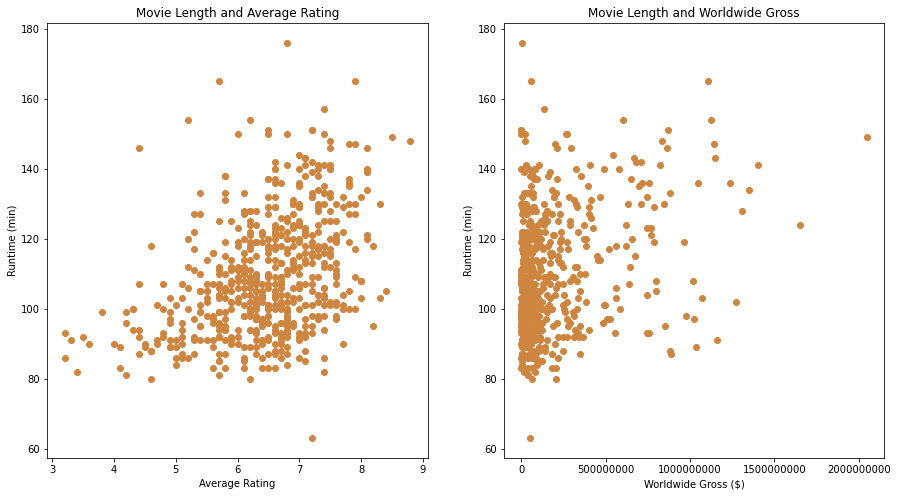

In [35]:
fig, (ax1, ax2) = plt.subplots(figsize=(15,8), ncols=2)

ax1.ticklabel_format(style='plain')
ax1.scatter(movies_sql2['averagerating'] , y = movies_sql2['runtime_minutes'], color="peru");

ax2.ticklabel_format(style='plain')
ax2.scatter(movies_sql2['worldwide_gross'] , y = movies_sql2['runtime_minutes'], color="peru");

ax1.set_title('Movie Length and Average Rating')
ax2.set_title('Movie Length and Worldwide Gross')
ax1.set_ylabel('Runtime (min)')
ax2.set_ylabel('Runtime (min)')
ax1.set_xlabel('Average Rating')
ax2.set_xlabel('Worldwide Gross ($)');

In [47]:
plt.savefig('./Untitled Folder/Movie Length Average Rating and Worldwide Gross.png')

<Figure size 432x288 with 0 Axes>

In [36]:
Worldwide_Gross_Run_Time_Correlation = np.corrcoef(movies_sql2['worldwide_gross'] , y = movies_sql2['runtime_minutes'])
Average_Rating_Run_Time_Correlation = np.corrcoef(movies_sql2['averagerating'] , y = movies_sql2['runtime_minutes'])

Worldwide_Gross_Run_Time_Correlation[0][1], Average_Rating_Run_Time_Correlation[0][1]


(0.3081442958209372, 0.41497783815113454)

# Avenues to Explore

Actors

# Junk

In [37]:
con.close() #have this in case file refuses to close

In [38]:
os.remove('im.db') #This line deletes the im.db file created earlier.